In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import skorch
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models
import collections

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

import numpy as np
import matplotlib
# matplotlib.use('agg')
import matplotlib.pyplot as plt
from Lung_dataset import ILDDataset

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [54]:
NUM_TOTAL = 656
NUM_TRAIN = 1808

#add path as absolute path for root dir

im_size = 256

lung_dataset_train = ILDDataset(csv_file=r'C:/Users/Akrofi/Desktop/CS 231/Project/train_labels.csv', 
                          root_dir=r'C:/Users/Akrofi/Desktop/CS 231/Project/New Folder',mask=True, train=True, resize=im_size)#, transform=transform)


#add path as absolute path for root dir
lung_dataset_test = ILDDataset(csv_file=r'C:/Users/Akrofi/Desktop/CS 231/Project/test_labels.csv', 
                          root_dir=r'C:/Users/Akrofi/Desktop/CS 231/Project/test', mask=True, train=False, resize=im_size)#, transform=transform)


loader_test = DataLoader(lung_dataset_train, batch_size=16, sampler=sampler.(range(NUM_TOTAL-NUM_TRAIN, NUM_TOTAL)))

loader_val = DataLoader(lung_dataset_train, batch_size=16, 
                          sampler=sampler.SequentialSampler(range(NUM_TOTAL-NUM_TRAIN)))

loader_train = DataLoader(lung_dataset_test, batch_size=16, 
                         sampler=sampler.SequentialSampler(range(336)))

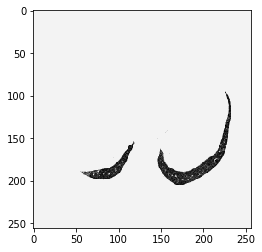

label: 1


In [55]:
#show datasample
sample = lung_dataset_train[120]
plt.imshow(sample[0], cmap='gray')
plt.show()
print("label: " + str(sample[1]))

In [56]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)


In [57]:
def get_model():
    """
    Used to fetch model for classification
    """
      
    in_channel = 1
    channel_1 = 32
    channel_2 = 64
    channel_3 = 32
    num_classes = 3

    model = nn.Sequential(
    nn.Conv3d(in_channel,channel_1, kernel_size=5, padding=2, stride= 1 ),
    nn.ReLU(),
    nn.Conv3d(channel_1, channel_2, kernel_size=3, padding=1, stride=1),
    nn.ReLU(),
    nn.BatchNorm3d(num_features= channel_2),
    nn.MaxPool3d(kernel_size=1,stride=1),
    nn.Conv3d(channel_2, channel_3, kernel_size=3, padding=1, stride=1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(2097152, num_classes)#/4
)

    
    return model
    

In [58]:
def check_accuracy(loader, model, train=False):
    if loader.dataset.train and train == True:
        print('Checking accuracy on training set')
    elif loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            [N,H,W] =  [*x.size()]
            
#             print(y)
            a = np.split(y,16)
            y = np.zeros(len(a))
            for i in range(len(a)):
                b = collections.Counter(a[i]).most_common()[0][0]
                y[i] = (b)
           
            y = torch.LongTensor(y)
            y = y.to(device=device, dtype=torch.long)

                                
            scores = model(x.view(16, 1 , 1, H , W))
            _, preds = scores.max(1)
            print(preds,y)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples      
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        
    return acc
 

In [59]:
def train(model, optimizer, epochs=1, overfit=False):
    """
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    best_acc = 0;
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            [N,H,W] =  [*x.size()]
            
#             print(y)
            a = np.split(y,16)
            y = np.zeros(len(a))
            for i in range(len(a)):
                b = collections.Counter(a[i]).most_common()[0][0]
                y[i] = b
           
            y = torch.LongTensor(y)
            y = y.to(device=device, dtype=torch.long)
            
            
#             weights = torch.cuda.FloatTensor([1/2, 1, 18/1000])
            scores = model(x.view(16, 1, 1, H , W))
            Loss = nn.CrossEntropyLoss()#weights
            loss = Loss(scores, y)
            
            
            reg = torch.tensor(1e-2, device= device, dtype=dtype)
            l2_reg = torch.tensor(0. , device= device, dtype=dtype)
            for param in model.parameters():
                l2_reg += torch.norm(param)
            loss += reg * l2_reg

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
#             if t % print_every == 0:
        print('Iteration %d, loss = %.4f' % (t, loss.item()))
        if(overfit):
            _ = check_accuracy(loader_train, model, train=True)
        acc = check_accuracy(loader_val, model)
        if acc > best_acc:
                best_acc = acc
                best_model = model
        print()
    return model

In [60]:
model1 = get_model()
optimizer = optim.Adam(model1.parameters(), lr = 0.001)
best_model = train(model1, optimizer, epochs= 10, overfit=True)

Iteration 20, loss = 25.6983
Checking accuracy on test set
tensor([ 1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2], device='cuda:0') tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2], device='cuda:0')
tensor([ 2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,
         1,  1], device='cuda:0') tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  1], device='cuda:0')
tensor([ 1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2], device='cuda:0') tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1], device='cuda:0')
tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,
         2,  2], device='cuda:0') tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,
         0,  0], device='cuda:0')
tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,
         2,  2], device='cuda:0') tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

         1,  1], device='cuda:0')
tensor([ 1,  0,  0,  0,  0,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  0], device='cuda:0') tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1], device='cuda:0')
tensor([ 0,  0,  0,  0,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0], device='cuda:0') tensor([ 1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0], device='cuda:0')
tensor([ 0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  2,  2,
         2,  2], device='cuda:0') tensor([ 0,  0,  0,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2], device='cuda:0')
tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  0], device='cuda:0') tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  0], device='cuda:0')
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0], device='cuda:0') tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0], dev

         2,  2], device='cuda:0') tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2], device='cuda:0')
tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,
         1,  1], device='cuda:0') tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  1], device='cuda:0')
tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1], device='cuda:0') tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1], device='cuda:0')
tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,
         0,  0], device='cuda:0') tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,
         0,  0], device='cuda:0')
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         2,  2], device='cuda:0') tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         2,  2], device='cuda:0')
tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2], dev

         2,  2], device='cuda:0')
tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,
         1,  1], device='cuda:0') tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  1], device='cuda:0')
tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1], device='cuda:0') tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1], device='cuda:0')
tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,
         0,  0], device='cuda:0') tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,
         0,  0], device='cuda:0')
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         2,  2], device='cuda:0') tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         2,  2], device='cuda:0')
tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2], device='cuda:0') tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2], dev

         1,  1], device='cuda:0') tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  1], device='cuda:0')
tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1], device='cuda:0') tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1], device='cuda:0')
tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,
         0,  0], device='cuda:0') tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,
         0,  0], device='cuda:0')
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         2,  2], device='cuda:0') tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         2,  2], device='cuda:0')
tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2], device='cuda:0') tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2], device='cuda:0')
tensor([ 2,  2,  2,  2,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0,
         0,  0], dev

In [61]:
#Check Test set
check_accuracy(loader_test, best_model)

Checking accuracy on validation set
tensor([ 1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  0], device='cuda:0') tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2], device='cuda:0')
tensor([ 0,  0,  2,  1,  1,  1,  1,  0,  2,  0,  2,  0,  1,  1,
         1,  2], device='cuda:0') tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2], device='cuda:0')
tensor([ 2,  1,  2,  0,  0,  1,  0,  0,  1,  1,  0,  1,  1,  0,
         2,  2], device='cuda:0') tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2], device='cuda:0')
tensor([ 2,  0,  2,  2,  2,  0,  2,  2,  0,  0,  2,  2,  2,  2,
         2,  0], device='cuda:0') tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2], device='cuda:0')
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  2,  2,
         2,  0], device='cuda:0') tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  0,  0,  0,
         0,  0], d

0.3267857142857143

In [15]:
 # Define model
    
   